In [2]:
import yfinance as yf
import pandas as pd
from ctw2 import CTW
import numpy as np  
import matplotlib.pyplot as plt 

# Définition des périodes d'entraînement et de test
train_start = "2018-01-01"  # Commencer plus tôt pour avoir plus de données
train_end = "2023-10-09"
test_start = "2023-10-10"
test_end = "2024-10-09"


# Définition des tickers en fonction de l'étude
tickers = {
    "S&P500": "^GSPC",
    "STOXX50": "^STOXX50E",
    "Hang Seng": "^HSI",
    "Nikkei225": "^N225",
    "FTSE100": "^FTSE",
    "DAX": "^GDAXI",
    "Russell 2000": "^RUT",
    "iShares MSCI Emerging Markets": "EEM",
    "Vanguard Total World Stock ETF": "VT",
    "VIX Index": "^VIX"
}

# Téléchargement des données
print("Téléchargement des données...")
data = yf.download(list(tickers.values()), start=train_start, end=test_end)

# Vérification que les données ont bien été récupérées
print("Colonnes disponibles après téléchargement :", data.columns)

# Vérifier si "Adj Close" existe
if "Close" in data:
    data = data["Close"] 
else:
    raise KeyError("La colonne 'Adj Close' est absente. Vérifie les données téléchargées.")

# Renommage des colonnes pour plus de lisibilité
columns_map = {
    "^GSPC": "S&P500",
    "^STOXX50E": "STOXX50",
    "^HSI": "Hang Seng",
    "^N225": "Nikkei225",
    "^FTSE": "FTSE100",
    "^GDAXI": "DAX",
    "^RUT": "Russell 2000",
    "EEM": "iShares MSCI Emerging Markets",
    "VT": "Vanguard Total World Stock ETF",
    "^VIX": "VIX Index"
}
data.rename(columns=columns_map, inplace=True)

# Vérification après renommage
print("Colonnes après renommage :", data.columns)

# Séparation en train/test
train_data = data.loc[train_start:train_end]
test_data = data.loc[test_start:test_end]

# Vérification finale
print(f"Taille totale : {len(data)} observations")
print(f"Train : {len(train_data)} observations | Test : {len(test_data)} observations")

# Affichage des premières lignes
train_data.head()


Téléchargement des données...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


Colonnes disponibles après téléchargement : MultiIndex([( 'Close',       'EEM'),
            ( 'Close',        'VT'),
            ( 'Close',     '^FTSE'),
            ( 'Close',    '^GDAXI'),
            ( 'Close',     '^GSPC'),
            ( 'Close',      '^HSI'),
            ( 'Close',     '^N225'),
            ( 'Close',      '^RUT'),
            ( 'Close', '^STOXX50E'),
            ( 'Close',      '^VIX'),
            (  'High',       'EEM'),
            (  'High',        'VT'),
            (  'High',     '^FTSE'),
            (  'High',    '^GDAXI'),
            (  'High',     '^GSPC'),
            (  'High',      '^HSI'),
            (  'High',     '^N225'),
            (  'High',      '^RUT'),
            (  'High', '^STOXX50E'),
            (  'High',      '^VIX'),
            (   'Low',       'EEM'),
            (   'Low',        'VT'),
            (   'Low',     '^FTSE'),
            (   'Low',    '^GDAXI'),
            (   'Low',     '^GSPC'),
            (   'Low',      '^H

Ticker,iShares MSCI Emerging Markets,Vanguard Total World Stock ETF,FTSE100,DAX,S&P500,Hang Seng,Nikkei225,Russell 2000,STOXX50,VIX Index
Date,,,,,,,,,,
2018-01-02,40.948368,64.229401,7648.100098,12871.389648,2695.810059,30515.310547,NaN,1550.010010,NaN,9.77
2018-01-03,41.340721,64.666687,7671.100098,12978.209961,2713.060059,30560.949219,NaN,1552.579956,3509.879883,9.15
2018-01-04,41.545410,65.052505,7695.899902,13167.889648,2723.989990,30736.480469,23506.330078,1555.719971,3568.879883,9.22
2018-01-05,41.903641,65.429779,7724.200195,13319.639648,2743.149902,30814.640625,23714.529297,1560.010010,3607.629883,9.22
2018-01-08,41.903641,65.498398,7696.500000,13367.780273,2747.709961,30899.529297,NaN,1561.810059,3616.449951,9.52


Step 1 : Récupération des indices boursiers & ETFs
Step 2: Calcul des Indicateurs Techniques
step 3: Ajout des Devises et Taux d’Intérêt

In [3]:
def calculate_technical_indicators(df, window_rsi=14, window_macd_short=12, window_macd_long=26, window_signal=9, window_boll=20):
    """Ajoute RSI, MACD et Bollinger Bands au dataset"""
    df = df.copy()
    
    # RSI (Relative Strength Index)
    delta = df["S&P500"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window_rsi).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_rsi).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    ema_short = df["S&P500"].ewm(span=window_macd_short, adjust=False).mean()
    ema_long = df["S&P500"].ewm(span=window_macd_long, adjust=False).mean()
    df["MACD"] = ema_short - ema_long
    df["MACD_Signal"] = df["MACD"].ewm(span=window_signal, adjust=False).mean()

    # Bollinger Bands
    rolling_mean = df["S&P500"].rolling(window=window_boll).mean()
    rolling_std = df["S&P500"].rolling(window=window_boll).std()
    df["Bollinger_High"] = rolling_mean + (2 * rolling_std)
    df["Bollinger_Low"] = rolling_mean - (2 * rolling_std)

    return df

# Calcul des indicateurs techniques pour train et test
train_data = calculate_technical_indicators(train_data)
test_data = calculate_technical_indicators(test_data)

# Vérification
train_data.head()


Ticker,iShares MSCI Emerging Markets,Vanguard Total World Stock ETF,FTSE100,DAX,S&P500,Hang Seng,Nikkei225,Russell 2000,STOXX50,VIX Index,RSI,MACD,MACD_Signal,Bollinger_High,Bollinger_Low
Date,,,,,,,,,,,,,,,
2018-01-02,40.948368,64.229401,7648.100098,12871.389648,2695.810059,30515.310547,NaN,1550.010010,NaN,9.77,NaN,0.000000,0.000000,NaN,NaN
2018-01-03,41.340721,64.666687,7671.100098,12978.209961,2713.060059,30560.949219,NaN,1552.579956,3509.879883,9.15,NaN,1.376068,0.275214,NaN,NaN
2018-01-04,41.545410,65.052505,7695.899902,13167.889648,2723.989990,30736.480469,23506.330078,1555.719971,3568.879883,9.22,NaN,3.310406,0.882252,NaN,NaN
2018-01-05,41.903641,65.429779,7724.200195,13319.639648,2743.149902,30814.640625,23714.529297,1560.010010,3607.629883,9.22,NaN,6.316614,1.969125,NaN,NaN
2018-01-08,41.903641,65.498398,7696.500000,13367.780273,2747.709961,30899.529297,NaN,1561.810059,3616.449951,9.52,NaN,8.963686,3.368037,NaN,NaN


In [4]:
# Définition des tickers pour les devises et taux d'intérêt
currency_tickers = {
    "EUR/USD": "EURUSD=X",
    "GBP/USD": "GBPUSD=X",
    "USD/JPY": "JPY=X",
    "USD/CNY": "CNY=X"
}

interest_rate_tickers = {
    "US 10Y Yield": "^TNX",
    "US 2Y Yield": "^IRX",
    "Germany 10Y Yield": "^GDAXI"
}

# Téléchargement des devises
print("Téléchargement des taux de change...")
currency_data = yf.download(list(currency_tickers.values()), start=train_start, end=test_end)["Close"]
currency_data.columns = currency_tickers.keys()

# Téléchargement des taux d'intérêt
print("Téléchargement des taux d'intérêt...")
rates_data = yf.download(list(interest_rate_tickers.values()), start=train_start, end=test_end)["Close"]
rates_data.columns = interest_rate_tickers.keys()

# Vérification des données téléchargées
print("Colonnes des taux de change :", currency_data.columns)
print("Colonnes des taux d'intérêt :", rates_data.columns)

# Fusion des données avec les datasets train et test en ajoutant des suffixes pour éviter les conflits
train_data = train_data.join(currency_data.loc[train_start:train_end], rsuffix="_currency")
test_data = test_data.join(currency_data.loc[test_start:test_end], rsuffix="_currency")

train_data = train_data.join(rates_data.loc[train_start:train_end], rsuffix="_rates")
test_data = test_data.join(rates_data.loc[test_start:test_end], rsuffix="_rates")

# Vérification après fusion
print("Colonnes après fusion :", train_data.columns)

# Affichage des premières lignes pour vérification
train_data.head()


[                       0%                       ]

Téléchargement des taux de change...


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  3 of 3 completed


Téléchargement des taux d'intérêt...
Colonnes des taux de change : Index(['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CNY'], dtype='object')
Colonnes des taux d'intérêt : Index(['US 10Y Yield', 'US 2Y Yield', 'Germany 10Y Yield'], dtype='object')
Colonnes après fusion : Index(['iShares MSCI Emerging Markets', 'Vanguard Total World Stock ETF',
       'FTSE100', 'DAX', 'S&P500', 'Hang Seng', 'Nikkei225', 'Russell 2000',
       'STOXX50', 'VIX Index', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_High',
       'Bollinger_Low', 'EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CNY',
       'US 10Y Yield', 'US 2Y Yield', 'Germany 10Y Yield'],
      dtype='object')


,iShares MSCI Emerging Markets,Vanguard Total World Stock ETF,FTSE100,DAX,S&P500,Hang Seng,Nikkei225,Russell 2000,STOXX50,VIX Index,...,MACD_Signal,Bollinger_High,Bollinger_Low,EUR/USD,GBP/USD,USD/JPY,USD/CNY,US 10Y Yield,US 2Y Yield,Germany 10Y Yield
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.948368,64.229401,7648.100098,12871.389648,2695.810059,30515.310547,NaN,1550.010010,NaN,9.77,...,0.000000,NaN,NaN,6.5058,1.201158,1.351132,112.769997,12871.389648,1.378,2.465
2018-01-03,41.340721,64.666687,7671.100098,12978.209961,2713.060059,30560.949219,NaN,1552.579956,3509.879883,9.15,...,0.275214,NaN,NaN,6.4940,1.206345,1.359619,112.244003,12978.209961,1.370,2.447
2018-01-04,41.545410,65.052505,7695.899902,13167.889648,2723.989990,30736.480469,23506.330078,1555.719971,3568.879883,9.22,...,0.882252,NaN,NaN,6.5031,1.201043,1.351132,112.607002,13167.889648,1.370,2.453
2018-01-05,41.903641,65.429779,7724.200195,13319.639648,2743.149902,30814.640625,23714.529297,1560.010010,3607.629883,9.22,...,1.969125,NaN,NaN,6.4933,1.206884,1.355289,112.782997,13319.639648,1.370,2.476
2018-01-08,41.903641,65.498398,7696.500000,13367.780273,2747.709961,30899.529297,NaN,1561.810059,3616.449951,9.52,...,3.368037,NaN,NaN,6.4875,1.203746,1.357589,113.153999,13367.780273,1.380,2.480


Finalisation du dataset

In [5]:
# 🔹 Vérification des valeurs manquantes avant correction
print("Nombre de NaN AVANT correction :")
print("Train :", train_data.isna().sum().sum(), "| Test :", test_data.isna().sum().sum())

# 🔹 Remplissage des valeurs manquantes avec la dernière valeur connue (Forward Fill)
train_data = train_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

# 🔹 Vérification après correction
print("Nombre de NaN APRÈS correction :", train_data.isna().sum().sum(), "| Test :", test_data.isna().sum().sum())

# 🔹 Vérification finale : Si des NaN restent, applique un "backward fill" pour combler les dernières valeurs manquantes
if train_data.isna().sum().sum() > 0 or test_data.isna().sum().sum() > 0:
    train_data = train_data.fillna(method="bfill")
    test_data = test_data.fillna(method="bfill")
    print("Correction supplémentaire avec backward fill appliquée.")

# 🔹 Définition des classes de rendement du S&P500
train_data["Returns"] = train_data["S&P500"].pct_change()
test_data["Returns"] = test_data["S&P500"].pct_change()

# 🔹 Suppression des premières lignes NaN après `pct_change()`
train_data = train_data.dropna(subset=["Returns"])
test_data = test_data.dropna(subset=["Returns"])

# 🔹 Définition de la fonction pour classifier les rendements manuellement
def classify_returns(r):
    if r < -0.005:  # -0.5%
        return "Strong Negative"
    elif -0.005 <= r < 0:  # Entre -0.5% et 0%
        return "Slightly Negative"
    elif 0 <= r < 0.005:  # Entre 0% et +0.5%
        return "Slightly Positive"
    else:  # ≥ +0.5%
        return "Strong Positive"

# 🔹 Application de la classification aux données
train_data["Class"] = train_data["Returns"].apply(classify_returns)
test_data["Class"] = test_data["Returns"].apply(classify_returns)

# 🔹 Vérification de la répartition des classes
print("Répartition des classes dans Train :")
print(train_data["Class"].value_counts())

print("\nRépartition des classes dans Test :")
print(test_data["Class"].value_counts())


# 🔹 Suppression de la colonne "Returns" après classification
train_data = train_data.drop(columns=["Returns"])
test_data = test_data.drop(columns=["Returns"])

# 🔹 Sauvegarde des datasets
train_data.to_csv("train_dataset_2019_2023.csv")
test_data.to_csv("test_dataset_2023_2024.csv")

print("\n✅ Train et Test datasets prêts et sauvegardés !")
print(f"Train : {len(train_data)} observations | Test : {len(test_data)} observations")

# 🔹 Affichage des premières lignes
train_data.head()


Nombre de NaN AVANT correction :
Train : 2559 | Test : 494
Nombre de NaN APRÈS correction : 74 | Test : 51
Correction supplémentaire avec backward fill appliquée.
Répartition des classes dans Train :
Class
Strong Positive      447
Slightly Positive    381
Strong Negative      368
Slightly Negative    305
Name: count, dtype: int64

Répartition des classes dans Test :
Class
Slightly Positive    80
Strong Positive      75
Slightly Negative    58
Strong Negative      46
Name: count, dtype: int64

✅ Train et Test datasets prêts et sauvegardés !
Train : 1501 observations | Test : 259 observations


C:\Users\Jacques\AppData\Local\Temp\ipykernel_25860\3093531559.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method="ffill")
C:\Users\Jacques\AppData\Local\Temp\ipykernel_25860\3093531559.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(method="ffill")
C:\Users\Jacques\AppData\Local\Temp\ipykernel_25860\3093531559.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method="bfill")
C:\Users\Jacques\AppData\Local\Temp\ipykernel_25860\3093531559.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_data.fillna(me

,iShares MSCI Emerging Markets,Vanguard Total World Stock ETF,FTSE100,DAX,S&P500,Hang Seng,Nikkei225,Russell 2000,STOXX50,VIX Index,...,Bollinger_High,Bollinger_Low,EUR/USD,GBP/USD,USD/JPY,USD/CNY,US 10Y Yield,US 2Y Yield,Germany 10Y Yield,Class
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,41.340721,64.666687,7671.100098,12978.209961,2713.060059,30560.949219,23506.330078,1552.579956,3509.879883,9.15,...,2944.65993,2592.864045,6.4940,1.206345,1.359619,112.244003,12978.209961,1.370,2.447,Strong Positive
2018-01-04,41.545410,65.052505,7695.899902,13167.889648,2723.989990,30736.480469,23506.330078,1555.719971,3568.879883,9.22,...,2944.65993,2592.864045,6.5031,1.201043,1.351132,112.607002,13167.889648,1.370,2.453,Slightly Positive
2018-01-05,41.903641,65.429779,7724.200195,13319.639648,2743.149902,30814.640625,23714.529297,1560.010010,3607.629883,9.22,...,2944.65993,2592.864045,6.4933,1.206884,1.355289,112.782997,13319.639648,1.370,2.476,Strong Positive
2018-01-08,41.903641,65.498398,7696.500000,13367.780273,2747.709961,30899.529297,23714.529297,1561.810059,3616.449951,9.52,...,2944.65993,2592.864045,6.4875,1.203746,1.357589,113.153999,13367.780273,1.380,2.480,Slightly Positive
2018-01-09,41.835403,65.609856,7731.000000,13385.589844,2751.290039,31011.410156,23849.990234,1560.099976,3622.870117,10.08,...,2944.65993,2592.864045,6.4976,1.197046,1.357128,113.140999,13385.589844,1.415,2.546,Slightly Positive


In [6]:
import pandas as pd

# 🔹 Calcul de la répartition des classes dans Train et Test
train_class_counts = train_data["Class"].value_counts().reset_index()
test_class_counts = test_data["Class"].value_counts().reset_index()

# 🔹 Renommer les colonnes
train_class_counts.columns = ['Class', 'Train Observations']
test_class_counts.columns = ['Class', 'Test Observations']

# 🔹 Fusionner
class_distribution = pd.merge(train_class_counts, test_class_counts, on='Class')

# 🔹 Calcul du pourcentage
total_train = class_distribution['Train Observations'].sum()
total_test = class_distribution['Test Observations'].sum()

class_distribution['Train %'] = (class_distribution['Train Observations'] / total_train * 100).round(2)
class_distribution['Test %'] = (class_distribution['Test Observations'] / total_test * 100).round(2)

# 🔹 Affichage
display(class_distribution)
print(class_distribution)


,Class,Train Observations,Test Observations,Train %,Test %
0,Strong Positive,447,75,29.78,28.96
1,Slightly Positive,381,80,25.38,30.89
2,Strong Negative,368,46,24.52,17.76
3,Slightly Negative,305,58,20.32,22.39


               Class  Train Observations  Test Observations  Train %  Test %
0    Strong Positive                 447                 75    29.78   28.96
1  Slightly Positive                 381                 80    25.38   30.89
2    Strong Negative                 368                 46    24.52   17.76
3  Slightly Negative                 305                 58    20.32   22.39


In [7]:
print("NaN restants dans Train :", train_data.isna().sum().sum())
print("NaN restants dans Test :", test_data.isna().sum().sum())


NaN restants dans Train : 0
NaN restants dans Test : 0


On va désormais implémenter le modèle random forest et comparer l'accuracy et l'importance des features

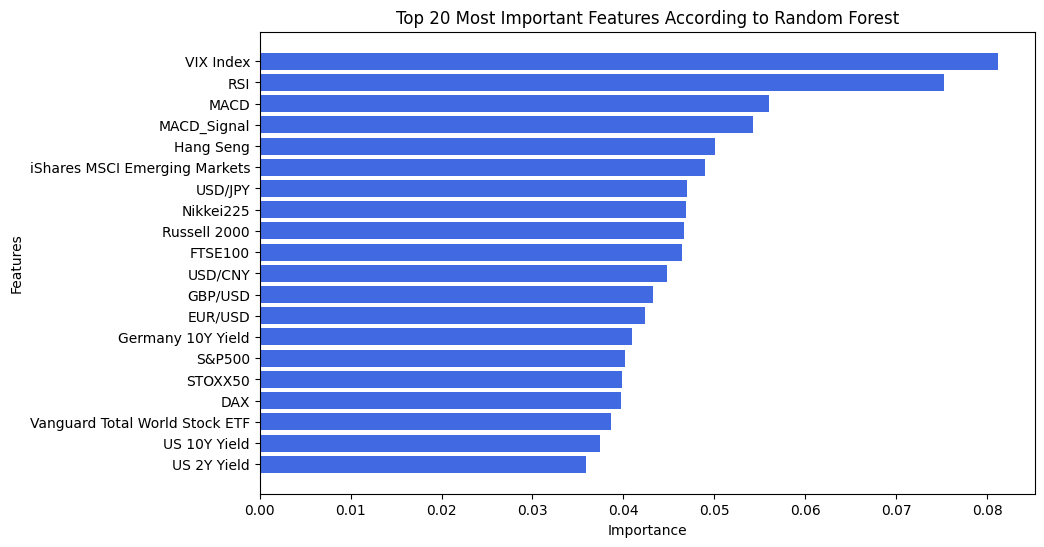

🔹 Nombre de features avant sélection : 22
✅ Nombre de features après sélection : 22
🔹 Nouvelle taille de X_train : (1501, 22)
🔹 Nouvelle taille de X_test : (259, 22)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Séparation des features (X) et des labels (y)
X_train = train_data.drop(columns=["Class"])
y_train = train_data["Class"]

X_test = test_data.drop(columns=["Class"])
y_test = test_data["Class"]

# 🔹 Entraînement du modèle Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# 🔹 Récupération de l'importance des features
feature_importances = rf.feature_importances_

# 🔹 Tri des features par importance
features_sorted = np.argsort(feature_importances)[::-1]
sorted_features = X_train.columns[features_sorted]
sorted_importance = feature_importances[features_sorted]

# 🔹 Affichage des 20 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:20], sorted_importance[:20], color="royalblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 20 Most Important Features According to Random Forest")
plt.gca().invert_yaxis()
plt.show()

# 🔹 Suppression des features les moins pertinentes (Optionnel)
threshold = 0.01  # On garde les features avec une importance > 1%
selected_features = sorted_features[sorted_importance > threshold]

print(f"🔹 Nombre de features avant sélection : {X_train.shape[1]}")
print(f"✅ Nombre de features après sélection : {len(selected_features)}")

# Création d'un nouveau dataset avec uniquement les meilleures features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Vérification de la nouvelle taille du dataset
print(f"🔹 Nouvelle taille de X_train : {X_train_selected.shape}")
print(f"🔹 Nouvelle taille de X_test : {X_test_selected.shape}")


In [9]:
sorted_features_names=list(sorted_features)[::-1]

In [10]:
sorted_features_names

['Bollinger_High',
 'Bollinger_Low',
 'US 2Y Yield',
 'US 10Y Yield',
 'Vanguard Total World Stock ETF',
 'DAX',
 'STOXX50',
 'S&P500',
 'Germany 10Y Yield',
 'EUR/USD',
 'GBP/USD',
 'USD/CNY',
 'FTSE100',
 'Russell 2000',
 'Nikkei225',
 'USD/JPY',
 'iShares MSCI Emerging Markets',
 'Hang Seng',
 'MACD_Signal',
 'MACD',
 'RSI',
 'VIX Index']

🟢 Feature supprimée: Bollinger_High | Nouvelle Accuracy: 0.3977
🟢 Feature supprimée: Bollinger_Low | Nouvelle Accuracy: 0.3900
🟢 Feature supprimée: US 2Y Yield | Nouvelle Accuracy: 0.3861
🟢 Feature supprimée: US 10Y Yield | Nouvelle Accuracy: 0.3900
🟢 Feature supprimée: Vanguard Total World Stock ETF | Nouvelle Accuracy: 0.3977
🟢 Feature supprimée: DAX | Nouvelle Accuracy: 0.4363
🟢 Feature supprimée: STOXX50 | Nouvelle Accuracy: 0.4208
🟢 Feature supprimée: S&P500 | Nouvelle Accuracy: 0.3900
🟢 Feature supprimée: Germany 10Y Yield | Nouvelle Accuracy: 0.4131
🟢 Feature supprimée: EUR/USD | Nouvelle Accuracy: 0.4015
🟢 Feature supprimée: GBP/USD | Nouvelle Accuracy: 0.3784
🟢 Feature supprimée: USD/CNY | Nouvelle Accuracy: 0.3900
🟢 Feature supprimée: FTSE100 | Nouvelle Accuracy: 0.4054
🟢 Feature supprimée: Russell 2000 | Nouvelle Accuracy: 0.4054
🟢 Feature supprimée: Nikkei225 | Nouvelle Accuracy: 0.4170
🟢 Feature supprimée: USD/JPY | Nouvelle Accuracy: 0.3822
🟢 Feature supprimée: iShares MS

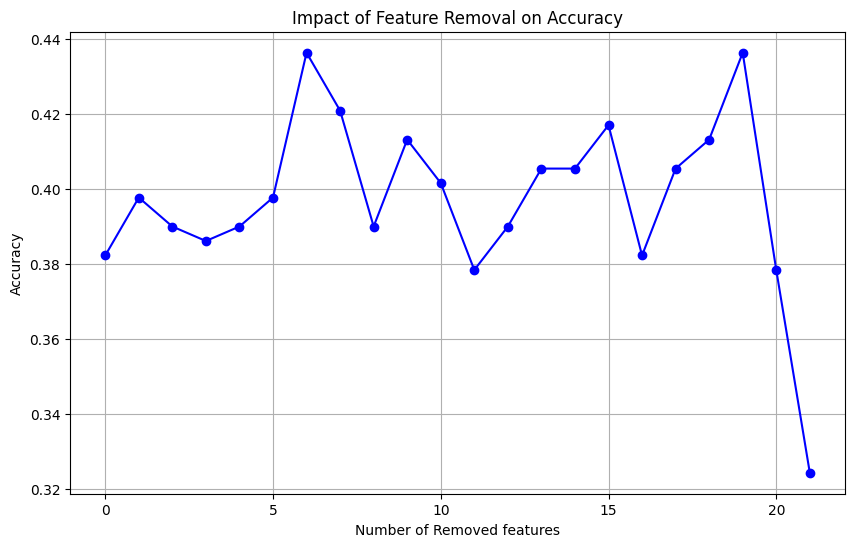

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 🔹 Initialisation
best_accuracy = 0  # Initialiser la meilleure accuracy
best_model = None  # Initialiser le modèle avec la meilleure accuracy
best_features = X_train.columns  # Liste des features avec la meilleure accuracy

# 🔹 Entraînement initial avec toutes les features
rf = RandomForestClassifier(n_estimators=50, criterion="gini", min_samples_leaf=10, random_state=42)
rf.fit(X_train, y_train)

# 🔹 Calcul de l'accuracy initiale
y_pred_initial = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred_initial)

# 🔹 Mise à jour de la meilleure accuracy et du meilleur modèle
best_accuracy = initial_accuracy
best_model = rf
best_features = X_train.columns

# 🔹 Liste pour suivre l'impact de chaque suppression
accuracies = [initial_accuracy]

# 🔹 Suppression progressive des features
X_train_progressive = X_train.copy()
X_test_progressive = X_test.copy()

for i in range(len(sorted_features)):
    feature_to_remove = sorted_features_names[i]
    
    # 🔹 Supprimer la feature
    X_train_progressive = X_train_progressive.drop(columns=[feature_to_remove])
    X_test_progressive = X_test_progressive.drop(columns=[feature_to_remove])

    # 🔹 Vérification que X_train_progressive et X_test_progressive ne sont pas vides
    if X_train_progressive.shape[1] == 0 or X_test_progressive.shape[1] == 0:
        print(f"🚨 Erreur : toutes les features ont été supprimées avant d'atteindre l'itération {i+1}.")
        break
    
    # 🔹 Entraînement du modèle avec les features restantes
    rf.fit(X_train_progressive, y_train)
    
    # 🔹 Prédictions sur les données de test
    y_pred_progressive = rf.predict(X_test_progressive)
    
    # 🔹 Calcul de l'accuracy après suppression
    accuracy = accuracy_score(y_test, y_pred_progressive)
    accuracies.append(accuracy)

    # 🔹 Mise à jour du meilleur modèle si l'accuracy s'améliore
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = rf
        best_features = X_train_progressive.columns

    print(f"🟢 Feature supprimée: {feature_to_remove} | Nouvelle Accuracy: {accuracy:.4f}")

# 🔹 Affichage de la meilleure accuracy et du meilleur modèle
print(f"\n✅ Meilleure accuracy obtenue : {best_accuracy:.4f}")
print(f"Meilleur modèle avec {len(best_features)} features.")

# 🔹 Affichage des résultats finaux
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o', linestyle='-', color='b')
plt.title("Impact of Feature Removal on Accuracy")
plt.xlabel("Number of Removed features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [12]:
# 🔹 Fonction pour convertir les rendements continus en classes discrètes
def convert_to_classes(r):
    if r < -0.005:  # -0.5%
        return 0  # "Strong Negative"
    elif -0.005 <= r < 0:  # Entre -0.5% et 0%
        return 1  # "Slightly Negative"
    elif 0 <= r < 0.005:  # Entre 0% et +0.5%
        return 2  # "Slightly Positive"
    else:  # ≥ +0.5%
        return 3  # "Strong Positive"

# 🔹 Appliquer la conversion des rendements sur X_train_ctw et X_test_ctw
train_classes = X_train["S&P500"].pct_change().apply(convert_to_classes)
test_classes = X_test["S&P500"].pct_change().apply(convert_to_classes)

# 🔹 Mise à jour des labels pour CTW
y_train_ctw = train_classes
y_test_ctw = test_classes


In [13]:
my_list=train_classes.values.tolist()
L= [int(x) for x in my_list]


Accuracy CTW (depth=1) with no side sequence: 0.2984
Accuracy CTW (depth=2) with no side sequence: 0.2879
Accuracy CTW (depth=3) with no side sequence: 0.2891
Accuracy CTW (depth=4) with no side sequence: 0.2863
Accuracy CTW (depth=5) with no side sequence: 0.2953
Accuracy CTW (depth=6) with no side sequence: 0.3478
Accuracy CTW (depth=7) with no side sequence: 0.3532
Accuracy CTW (depth=8) with no side sequence: 0.3506
Accuracy CTW (depth=9) with no side sequence: 0.3520
Accuracy CTW (depth=10) with no side sequence: 0.3574


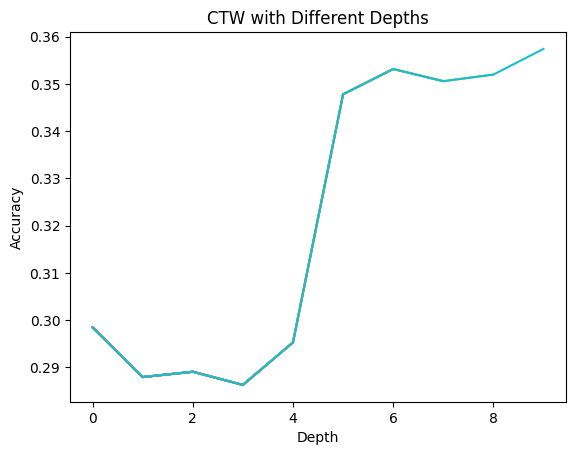

In [14]:
depth_max=10
L=[]
for depth in range(1,depth_max+1):
    ctw_model = CTW(depth=depth, symbols=4)
    
    ctw_model.predict_sequence(seq=train_classes.values.tolist(),sideseq=None)
    
    distributions = ctw_model.predict_sequence(test_classes.values.tolist())
    y_pred_ctw=np.argmax(distributions, axis=0)
    
    ctw_accuracy = accuracy_score(test_classes.values.tolist()[depth:], y_pred_ctw)
    print(f"Accuracy CTW (depth={depth}) with no side sequence: {ctw_accuracy:.4f}")
    L.append(ctw_accuracy)
    plt.plot(L)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("CTW with Different Depths")
plt.show(block=True)

In [15]:
from tqdm import tqdm

# === 1. Fonction d'encodage personnalisée ===
def convert_to_classes(r):
    if r < -0.005:
        return 0  # Strong Negative
    elif -0.005 <= r < 0:
        return 1  # Slightly Negative
    elif 0 <= r < 0.005:
        return 2  # Slightly Positive
    else:
        return 3  # Strong Positive
def vix_binary_class(r):
    return 0 if r < 0 else 1  # 0 = VIX en baisse, 1 = VIX en hausse

In [16]:
start_date = "2015-01-01"
end_date = "2024-12-31"

df = yf.download(['^GSPC', '^FCHI'], start=start_date, end=end_date)['Close']
df.columns = ['SP500', 'FCHI']
df = df.dropna()

[*********************100%***********************]  2 of 2 completed


[*********************100%***********************]  11 of 11 completed



▶️ Testing side-info: ^VIX



▶️ Testing side-info: ^TNX



▶️ Testing side-info: DXY



▶️ Testing side-info: SPY



▶️ Testing side-info: HYG



▶️ Testing side-info: LQD



▶️ Testing side-info: ^IRX



▶️ Testing side-info: ^FVX



▶️ Testing side-info: ^TYX



▶️ Testing side-info: ^IXIC


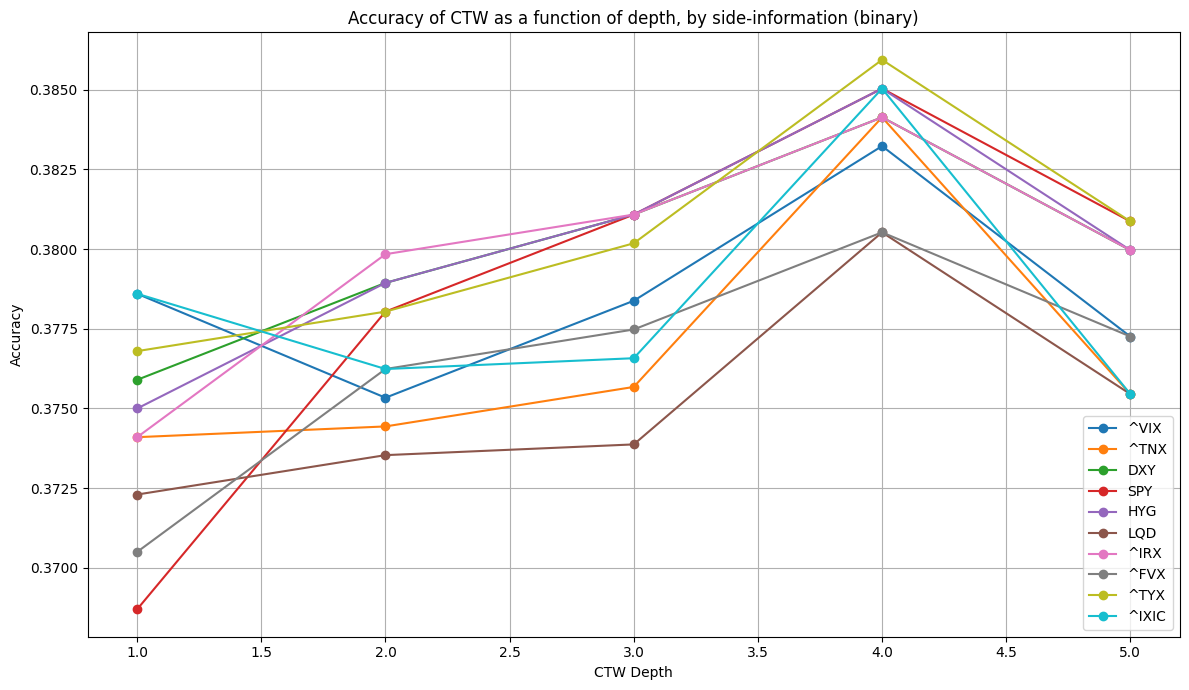

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# === 1. Paramètres ===
depths = list(range(1, 6))  # Profondeur CTW à tester
symbols = 4
side_classes = 2  # Codage binaire des side-seq

# === 2. Fonction d'encodage principale ===
def convert_to_classes(r):
    if r < -0.005:
        return 0
    elif -0.005 <= r < 0:
        return 1
    elif 0 <= r < 0.005:
        return 2
    else:
        return 3

# === 3. Liste des side-features (indices) à tester ===
index_tickers = [
    "^VIX", "^TNX", "DXY", "SPY", "HYG", "LQD", "^IRX", "^FVX", "^TYX", "^IXIC"
]

# === 4. Téléchargement des données Yahoo Finance ===
start_date = "2015-01-01"
end_date = "2024-12-31"

tickers_all = ["^GSPC"] + index_tickers
df_all = yf.download(tickers_all, start=start_date, end=end_date)['Close']
df_all.columns = ['SP500'] + index_tickers
df_all = df_all.dropna()

# === 5. Préparer la séquence principale (S&P500) ===
sp500_returns = df_all['SP500'].pct_change().fillna(0)
seq = sp500_returns.apply(convert_to_classes).tolist()

# === 6. Stockage des courbes d'accuracy ===
accuracy_curves = {}

for ticker in index_tickers:
    print(f"\n▶️ Testing side-info: {ticker}")
    acc_list = []

    # Préparer la sideseq binaire (hausse/baisse)
    side_ret = df_all[ticker].pct_change().fillna(0)
    sideseq = side_ret.apply(lambda r: 0 if r < 0 else 1).tolist()

    # Aligner les longueurs
    min_len = min(len(seq), len(sideseq))
    s = seq[:min_len]
    side = sideseq[:min_len]

    # Boucle sur les profondeurs
    for d in tqdm(depths, desc=f"Depth loop for {ticker}", leave=False):
        try:
            ctw = CTW(depth=d, symbols=symbols, sidesymbols=side_classes)
            dist = ctw.predict_sequence(s, sideseq=side)

            preds = np.argmax(dist, axis=0)
            true_labels = np.array(s[d:])
            acc = np.mean(preds == true_labels)
        except Exception as e:
            acc = None
            print(f"❌ Erreur avec {ticker} à profondeur {d}: {e}")

        acc_list.append(acc)

    accuracy_curves[ticker] = acc_list

# === 7. Tracer toutes les courbes ===
plt.figure(figsize=(12, 7))
for ticker, accs in accuracy_curves.items():
    if None not in accs:
        plt.plot(depths, accs, marker='o', label=ticker)

plt.title("Accuracy of CTW as a function of depth, by side-information (binary)")
plt.xlabel("CTW Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


[*********************100%***********************]  5 of 5 completed



▶️ Testing combo: ^TYX + ^IXIC



▶️ Testing combo: ^TYX + HYG



▶️ Testing combo: ^TYX + SPY



▶️ Testing combo: ^IXIC + HYG



▶️ Testing combo: ^IXIC + SPY



▶️ Testing combo: HYG + SPY


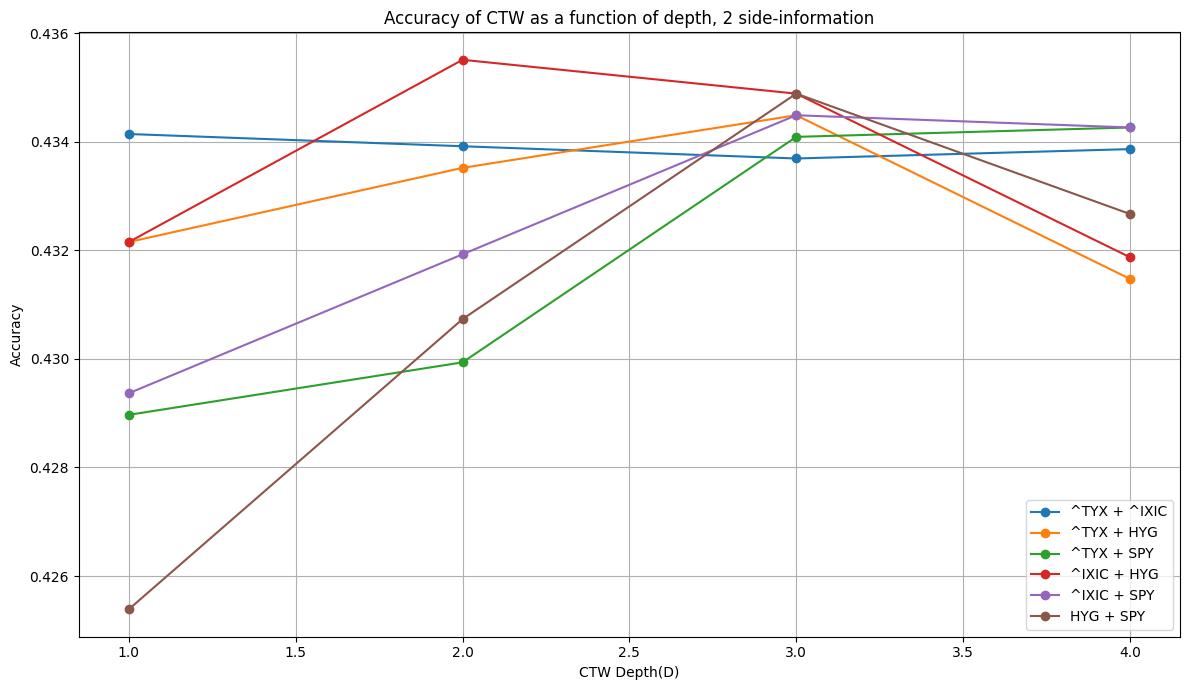

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations

# === Paramètres ===
depths = list(range(1, 5))  # Tester D de 1 à 10
symbols = 4
sidesymbols = 4  # 2 classes * 2 classes = 4 états combinés

# === Fonction d'encodage S&P500 (principal) ===
def convert_to_classes(r):
    if r < -0.005:
        return 0
    elif -0.005 <= r < 0:
        return 1
    elif 0 <= r < 0.005:
        return 2
    else:
        return 3

# === Tickers sélectionnés ===
selected_tickers = ["^TYX", "^IXIC", "HYG", "SPY"]

# === Télécharger les données ===
tickers_all = ["^GSPC"] + selected_tickers
df = yf.download(tickers_all, start="2015-01-01", end="2024-12-31")['Close']
df.columns = ['SP500'] + selected_tickers
df = df.dropna()

# === Séquence principale : SP500 encodé en 4 classes ===
sp500_returns = df['SP500'].pct_change().fillna(0)
seq = sp500_returns.apply(convert_to_classes).tolist()

# === Stocker les courbes d'accuracy pour chaque duo ===
accuracy_curves = {}

for ticker1, ticker2 in combinations(selected_tickers, 2):
    combo_name = f"{ticker1} + {ticker2}"
    print(f"\n▶️ Testing combo: {combo_name}")
    accs = []

    # Side-seq binaires pour chaque ticker
    side1 = df[ticker1].pct_change().fillna(0).apply(lambda r: 0 if r < 0 else 1).tolist()
    side2 = df[ticker2].pct_change().fillna(0).apply(lambda r: 0 if r < 0 else 1).tolist()

    # Combinaison des deux → 4 états
    sideseq = [2 * s1 + s2 for s1, s2 in zip(side1, side2)]

    # Alignement des longueurs
    min_len = min(len(seq), len(sideseq))
    s = seq[:min_len]
    side = sideseq[:min_len]

    for d in tqdm(depths, desc=f"Profondeur pour {combo_name}", leave=False):
        try:
            ctw = CTW(depth=d, symbols=symbols, sidesymbols=sidesymbols)
            dist = ctw.predict_sequence(s, sideseq=side)

            preds = np.argmax(dist, axis=0)
            true_labels = np.array(s[d:])
            acc = np.mean(preds == true_labels)
        except Exception as e:
            print(f"❌ Erreur avec {combo_name} à D={d} : {e}")
            acc = None

        accs.append(acc)

    accuracy_curves[combo_name] = accs

# === Tracer les courbes ===
plt.figure(figsize=(12, 7))

for combo_name, accs in accuracy_curves.items():
    if None not in accs:
        plt.plot(depths, accs, marker='o', label=combo_name)

plt.title("Accuracy of CTW as a function of depth, 2 side-information")
plt.xlabel("CTW Depth(D)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


[*********************100%***********************]  5 of 5 completed



▶️ Testing combo: ^TYX + ^IXIC + HYG



▶️ Testing combo: ^TYX + ^IXIC + SPY



▶️ Testing combo: ^TYX + HYG + SPY



▶️ Testing combo: ^IXIC + HYG + SPY


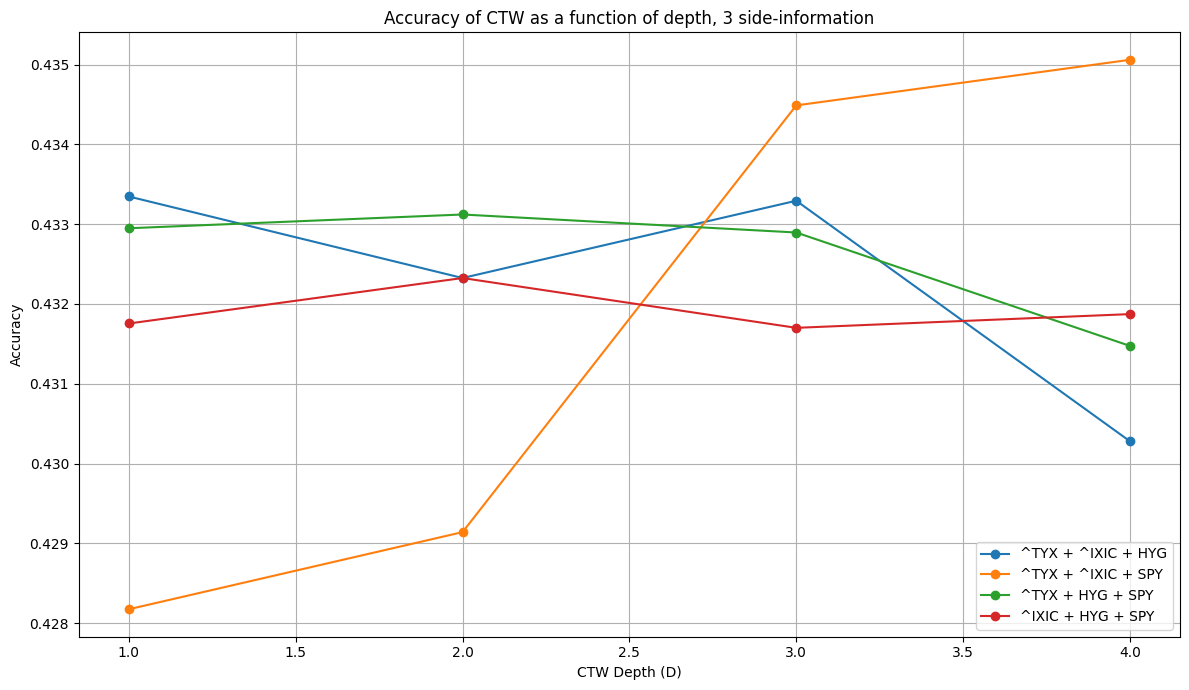

In [22]:

from itertools import combinations

# === Paramètres ===
depths = list(range(1, 5))  # Profondeurs de CTW à tester
symbols = 4                  # Alphabet de la séquence principale
sidesymbols = 8              # 2^3 = 8 états possibles pour 3 sideseq binaires

# === Fonction d'encodage S&P500 en 4 classes ===
def convert_to_classes(r):
    if r < -0.005:
        return 0
    elif -0.005 <= r < 0:
        return 1
    elif 0 <= r < 0.005:
        return 2
    else:
        return 3

# === Tickers sélectionnés ===
selected_tickers = ["^TYX", "^IXIC", "HYG", "SPY"]

# === Télécharger les données depuis Yahoo Finance ===
tickers_all = ["^GSPC"] + selected_tickers
df = yf.download(tickers_all, start="2015-01-01", end="2024-12-31")['Close']
df.columns = ['SP500'] + selected_tickers
df = df.dropna()

# === Séquence principale : SP500 encodée ===
sp500_returns = df['SP500'].pct_change().fillna(0)
seq = sp500_returns.apply(convert_to_classes).tolist()

# === Stockage des courbes d'accuracy ===
accuracy_curves = {}

# === Tester chaque trio de tickers ===
for ticker1, ticker2, ticker3 in combinations(selected_tickers, 3):
    combo_name = f"{ticker1} + {ticker2} + {ticker3}"
    print(f"\n▶️ Testing combo: {combo_name}")
    accs = []

    # Sideseqs binaires
    side1 = df[ticker1].pct_change().fillna(0).apply(lambda r: 0 if r < 0 else 1).tolist()
    side2 = df[ticker2].pct_change().fillna(0).apply(lambda r: 0 if r < 0 else 1).tolist()
    side3 = df[ticker3].pct_change().fillna(0).apply(lambda r: 0 if r < 0 else 1).tolist()

    # Combinaison des 3 binaires → 8 états
    sideseq = [4 * s1 + 2 * s2 + s3 for s1, s2, s3 in zip(side1, side2, side3)]

    # Alignement
    min_len = min(len(seq), len(sideseq))
    s = seq[:min_len]
    side = sideseq[:min_len]

    for d in tqdm(depths, desc=f"Profondeur pour {combo_name}", leave=False):
        try:
            ctw = CTW(depth=d, symbols=symbols, sidesymbols=sidesymbols)
            dist = ctw.predict_sequence(s, sideseq=side)

            preds = np.argmax(dist, axis=0)
            true_labels = np.array(s[d:])
            acc = np.mean(preds == true_labels)
        except Exception as e:
            print(f"❌ Erreur avec {combo_name} à D={d} : {e}")
            acc = None

        accs.append(acc)

    accuracy_curves[combo_name] = accs

# === Tracer les courbes ===
plt.figure(figsize=(12, 7))

for combo_name, accs in accuracy_curves.items():
    if None not in accs:
        plt.plot(depths, accs, marker='o', label=combo_name)

plt.title("Accuracy of CTW as a function of depth, 3 side-information")
plt.xlabel("CTW Depth (D)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
